### M3 Week 2 Group 8: Daniel Azemar, María Gil, Richard Segovia

## Report structure
First you can find the main code if you want to look the results scroll down

In [2]:
import cv2
import numpy as np
import pickle
from tqdm import tqdm
import random

from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer, StandardScaler

from assessment import showConfusionMatrix, plot, get_max_key
from descriptors import get_bag_of_words, get_visual_words, compute_descriptors, get_pyramid_visual_word_len, select_descriptors
from classifiers import get_dist_func, select_svm_kernel
from main import save_data, load_data

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
class Classification(object):
    def __init__(self):
        # Load train and test files
        self.total_train_images_filenames = pickle.load(open('./train_images_filenames.dat', 'rb'))
        self.total_test_images_filenames = pickle.load(open('./test_images_filenames.dat', 'rb'))
        self.total_train_labels = pickle.load(open('./train_labels.dat', 'rb'))
        self.total_test_labels = pickle.load(open('./test_labels.dat', 'rb'))

        #Cross-validation parameters
        self.split_num = 3 #number of k-folds

        # Descriptors parameters
        self.kp_detector = 'dense' # sift dense
        self.desc_type = 'sift' # sift
        self.n_descriptors = 600

        # Dense SIFT parameters
        self.stepValue = 10
        self.scale_mode = "multiple"  # multiple random, uniform, gauss
        # uniform scale params
        self.maxScale = 15
        self.minScale = 7
        # gauss scale params
        self.mean = 15
        self.desvt = 7

        #BagOfVisualWords parameters
        self.mode_bagofWords = 'all' # all pyramids
        self.reduce_num_of_features = True
        self.features_per_img = 100

        #Spatial pyramid params
        self.levels_pyramid = 2
        self.codebook_size = 128
        self.normalize_level_vw = True
        self.scaleData_level_vw = False

        #Data normalization and scalation
        self.normalize = True
        self.scaleData = False

        #Classifier parameters
        self.classif_type  =  'svm' # knn svm
        self.knn_metric = 'euclidean'
        self.svm_metric = 'hist_intersection' #'rbf' or 'hist_intersection'
        self.save_trainData = False
        #SVM parameters
        self.C=1.0
        self.degree=3
        self.gamma='auto'


    def compute(self):
        # Split train dataset for cross-validation
        cv = StratifiedKFold(n_splits=self.split_num)

        accumulated_accuracy=[]        
        for train_index, val_index in cv.split(self.total_train_images_filenames, self.total_train_labels):
            #train_index = train_index[:200]
            #val_index = val_index[:200]
            train_filenames = [self.total_train_images_filenames[index] for index in train_index]
            train_labels = [self.total_train_labels[index] for index in train_index]
            val_filenames = [self.total_train_images_filenames[index] for index in val_index]
            val_labels = [self.total_train_labels[index] for index in val_index]

            # TRAIN CLASSIFIER
            keypoint_list = []
            train_desc_list = []
            train_label_per_descriptor = []

            for filename, labels in zip(tqdm(train_filenames, desc="train descriptors"), train_labels):
                ima = cv2.imread(filename)
                kpt, des = compute_descriptors(ima, self.kp_detector, self.desc_type, self.stepValue, self.scale_mode, self.minScale, self.maxScale, self.mean, self.desvt, self.n_descriptors)
                keypoint_list.append(kpt)
                train_desc_list.append(des)
                train_label_per_descriptor.append(labels)
            
            D = np.vstack(train_desc_list)

            # reducing the number of descriptors used in bag of words
            if(self.reduce_num_of_features):
                selected_index = select_descriptors(train_desc_list, self.features_per_img)
                D = D[selected_index]

            # 3. Create codebook and fit with train dataset
            codebook, visual_words = get_bag_of_words(self.levels_pyramid, self.mode_bagofWords, D, train_desc_list, keypoint_list, self.codebook_size, normalize_level_vw=self.normalize_level_vw, scaleData_level_vw=self.scaleData_level_vw)

            # 4. self.normalize and scale descriptors
            if(self.normalize):
                norm_model = Normalizer().fit(visual_words) #l2 norm by default
                visual_words = norm_model.fit_transform(visual_words)

            #scaling
            if(self.scaleData):
                scale_model = StandardScaler().fit(visual_words)
                visual_words = scale_model.fit_transform(visual_words)


            # 5. Train classifier
            model = None
            if self.classif_type == 'knn':
                model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric=get_dist_func(self.knn_metric))
                model.fit(visual_words, train_labels)
            elif self.classif_type == 'svm':
                svm_kernel = select_svm_kernel(self.svm_metric)
                model = SVC(C=self.C, kernel=svm_kernel, degree=self.degree, gamma=self.gamma, shrinking=False, probability=False, tol=0.001, max_iter=-1)
                model.fit(visual_words, train_labels)
            else:
                raise (NotImplemented("self.classif_type not implemented or not recognized:" + str(self.classif_type)))

            # 6. Save/load data in pickle
            if self.save_trainData:
                save_data(codebook, "codebook.pkl")
                save_data(visual_words, "visual_words.pkl")
            else:
                pass
                #codebook = load_data("codebook.pkl")
                #visual_words = load_data("visual_words.pkl")

            # VALIDATE CLASSIFIER WITH CROSS-VALIDATION DATASET

            if(self.mode_bagofWords == 'all'):
                visual_words_test = np.zeros((len(val_filenames), self.codebook_size), dtype=np.float32)
            if(self.mode_bagofWords == 'pyramids'):
                len_vw = get_pyramid_visual_word_len(self.levels_pyramid,self.codebook_size)
                visual_words_test = np.zeros((len(val_filenames), len_vw), dtype=np.float32)

            for i in tqdm(range(len(val_filenames)), desc="test descriptors"):
                filename = val_filenames[i]
                ima = cv2.imread(filename)
                kpt, des = compute_descriptors(ima, self.kp_detector, self.desc_type, self.stepValue, self.scale_mode, self.minScale, self.maxScale, self.mean, self.desvt, self.n_descriptors )

                _, visual_words_test[i,:] = get_visual_words(self.levels_pyramid, self.mode_bagofWords, codebook, des, kpt, self.codebook_size,  normalize_level_vw=self.normalize_level_vw, scaleData_level_vw=self.scaleData_level_vw)

            if(self.normalize):
                visual_words_test = norm_model.transform(visual_words_test)
            if(self.scaleData):
                visual_words_test = scale_model.transform(visual_words_test)

            # ASSESSMENT OF THE CLASSIFIER
            accuracy = 100 * model.score(visual_words_test, val_labels)
            accumulated_accuracy.append(accuracy)

            # Show Confusion Matrix
            # showConfusionMatrix(dist_name_list, conf_mat_list, labels_names)

        return np.sum(accumulated_accuracy)/len(accumulated_accuracy)

# Results

### Cross-validation
Along the experiments implemented in this report, we used the cross-validation method: StratifiedKFolds, from the scikit-learn library. The number of subsets was set to 3.

In [5]:
#Initialize class Classification() with default parameters
classifier_images = Classification()

### Descriptor extraction improvements
#### Use less descriptors for the kmeans training
Use Dense SIFT with a step size of 15 and 4 different scales from [4, 8, 12, 16]. 
Select a random selection of a subset of keypoints for clustering when generating the codebook.

In [17]:
#Set experiment parameters
classifier_images.reduce_num_of_features = True
classifier_images.stepValue = 12
features_per_imgs = [10, 50, 100, 250, 500]
results_features_per_img = {}
#Run experiment
for features_per_img in features_per_imgs:
    classifier_images.features_per_img = features_per_img
    results_features_per_img[features_per_img] = classifier_images.compute()
classifier_images.features_per_img = get_max_key(results_features_per_img)

test descriptors: 100%|██████████████████████████████████████████████████████████████| 623/623 [01:10<00:00,  8.94it/s]


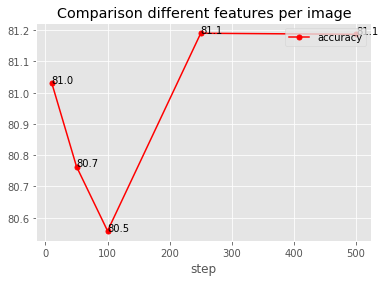

In [7]:
#TODO print grafica 
plot(results_features_per_img, title="Comparison different features per image", xlabel="step")

In [16]:
#TODO escribir analisis

#### Use dense sift even more dense

In [11]:
#Set experiment parameters
step_values = [4, 5, 7, 10, 12]
results_dense_sift = {}
#Run experiment
for step_val in step_values:
    classifier_images.stepValue = step_val
    results_dense_sift[step_val] = classifier_images.compute()
classifier_images.stepValue = get_max_key(results_dense_sift)

test descriptors: 100%|██████████████████████████████████████████████████████████████| 623/623 [01:34<00:00,  6.76it/s]


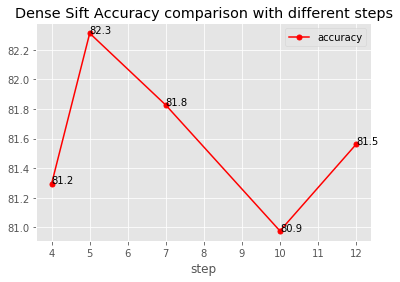

In [12]:
#TODO escribir analisis
plot(results_dense_sift, title="Dense Sift Accuracy comparison with different steps", xlabel="step")

#### Spatial Pyramids
Even with Dense SIFT descriptors, there is a lack of spatial information that can be very useful at classification. In order to preserve this information, we introduced the Spatial Pyramid implementation at the codebook and bag of visual words step. Data is normalized before being stacked, otherwise the resulting descriptors would not have the same relevance depending on their scale.

In [ ]:
#Pyramid levels selection
classifier_images.mode_bagofWords = "pyramid"
levels = [2,3,4]
results_pyramid_levels = {}
#Run experiment
for level in levels:
    classifier_images.levels_pyramid = level
    results_pyramid_levels[subset_size] = classifier_images.compute()
classifier_images.levels_pyramid = get_max_key(results_pyramid_levels)

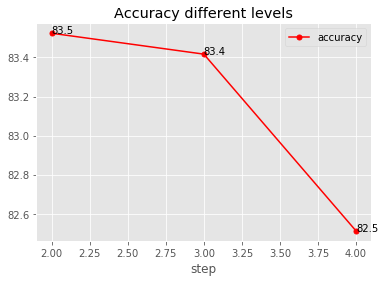

In [14]:
#TODO analizar resultados con distintos niveles
plot(results_pyramid_levels, title="Accuracy different levels", xlabel="step")

In [15]:
#Analyze improvement introduced by spatial pyramids
classifier_images.mode_bagofWords = "all"
print("not using spatial pyramid accuracy:",classifier_images.compute())

classifier_images.mode_bagofWords = "pyramid"
print("using spatial pyramid accuracy:",classifier_images.compute())

not using spatial pyramid accuracy: 80.39%
using spatial pyramid accuracy: 83.63%


### Introducing the SVM classifier
#### Parameter selection: cost and gamma
Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words``C`` behaves as a regularization parameter in the SVM.

In [ ]:
#Set experiment parameters
cost = [2,4,8,16]
gamma = [1,2,4,8,16,32]
results_svm_params = {}
#Run experiment
for c in cost:
    classifier_images.C = c
    for g in gamma:
        classifier_images.gamma = g
        results_svm_kernels[str([c,g])] = classifier_images.compute()

In [ ]:
#TODO comparar resultados con distintas gammas
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.plot_wireframe(cost, gamma, z, )
ax.legend(loc="upper right")
for i, j in zip(x, y):
    ax.annotate(str(j)[:4], xy=(i,j))
ax.set_title(title)
plt.xlabel(xlabel)

In [ ]:
#maybe TODO: comparar con gamma auto

#### Kernel selection: linear, RBF, histogram_intersection
The scikit-learn library provides some tools to find the decision boundary, as the linear or RBF kernel. However, in the case of our data, since we aim to compare histograms, a histogram intersection kernel tool has also been implemented. During this experiment we run a comparison between the three different kernels and provide some analysis.

In [6]:
#Set experiment parameters
kernels = ['hist_intersection']
results_svm_kernels = {}
#Run experiment
classifier_images.C = 1
classifier_images.mode_bagofWords = "pyramids"
classifier_images.stepValue = 10
for kernel in kernels:
    classifier_images.svm_metric = kernel
    results_svm_kernels[kernel] = classifier_images.compute()
classifier_images.svm_metric = get_max_key(results_svm_kernels)

test descriptors: 100%|██████████████████████████████████████████████████████████████| 623/623 [02:13<00:00,  4.01it/s]


In [7]:
results_svm_kernels


{'hist_intersection': 83.52097223309693}

In [ ]:
plot(results_svm_kernels)
#TODO comparar resultados con los kernels

### Codebook size selection
When using SVM instead of the KNN classifier, the codebook size plays an important role as well. In the following experiment we iterated over different values for the codebook size and selected the one with the best cross-validated score.

In [ ]:
codebook_sizes = [128, 256]

for codebook_size in codebook_sizes:
    classifier_images.codebook_size = codebook_size
    print(classifier_images.compute())
    

In [ ]:
#TODO comparar resultados con distintos tamaños

### Use of normalization and scaling
Effects of normalizing and/or scaling data before training the classifier

In [ ]:
#Run experiment with and without data normalization
classifier_images.normalize = True
classifier_images.scaleData = False
print(classifier_images.compute())

classifier_images.normalize = False
classifier_images.scaleData = True
print(classifier_images.compute())

test descriptors:  78%|████████████████████████████████████████████████              | 486/627 [01:37<00:30,  4.62it/s]

In [ ]:
# TODO comparar ambos